In [1]:
import fiftyone as fo
import matplotlib.pyplot as plt
%matplotlib widget 
import numpy as np
import copy
import scipy as sp

dataset = fo.load_dataset("RumexWeeds")
session = fo.Session(dataset=dataset, auto=False)

In [2]:
#Gets the sequence tags
tags = set()
for x in dataset.values("tags"):
    tags = tags.union(x)

In [3]:
bbox_dict = {}
for tag in tags:
    if "seq" in tag:
        sequence = dataset.match_tags(tag)
        bbox_dict[tag ]= sequence.values("ground_truth_detections.detections.bounding_box")
        break        


In [4]:
class KalmanNd:
    def __init__(self, x_initial, P_initial, H, R, F):
        self.x_initial = x_initial
        self.P_initial = P_initial
        self.x = x_initial # mean_vector (states)
        self.P = P_initial # covariance matrix
        self.H = H #Observability matrix
        self.R = R #Measurement uncertainty
        self.F = F
        self.x_hist = []
        self.P_hist = []
        self.updated = []
        self.locked = False
        self.I = np.eye(x_initial.shape[0])#np.zeros((x_initial.shape[0], x_initial.shape[0]))
        #np.fill_diagonal(self.I, 1)
    
    def lock(self):
        self.locked = True

    def update(self, Z):
        """Kalman filter measurement update
        Alters the object and updates the Kalman filter with a current measurement.
        Paramaters
        -----------
        Z : ndarray 
            The measurements to use for the update
        """
        if not self.locked:
            y = Z.reshape(-1,1) - np.dot(self.H, self.x)
            S = np.dot(np.dot(self.H,self.P), self.H.T) + self.R
            K = np.dot(np.dot(self.P,self.H.T), np.linalg.pinv(S))
            
            #Removed the update, but rather overwrite the prediction with the update
            self.x_hist[-1] = (copy.deepcopy(self.x))
            self.x = self.x + np.dot(K,y)
            self.P_hist.append(copy.deepcopy(self.P))
            self.P = np.dot((self.I - np.dot(K, self.H)), self.P)
            self.updated[-1] = True
    def predict(self, u=None):
        if not self.locked:
            ### insert predict function
            if u is None:
                u = np.zeros_like(self.x)
            self.x_hist.append(copy.deepcopy(self.x))
            self.x = np.dot(self.F,self.x) + u
            self.P_hist.append(copy.deepcopy(self.P))
            self.P = np.dot(np.dot(self.F, self.P), self.F.T)
            self.updated.append(False)
    def get_ellipsis(self, conf=0.95):
        """Returns the center point, minor and major axis of the ellipsis"""
        
        #Get the observables (columns/rows)
        axs = [x[0] for x in np.argwhere(self.H)]
        #Construct the custom covariance matrix
        P_sub = self.P[np.ix_(axs, axs)]
        #Get the eigenvectors
        ev, evec = sp.linalg.eig(P_sub)
        conf_length = sp.stats.chi2.ppf(conf, P_sub.shape[0])
        #Note that this is just half the length (so you can do center +- length)
        axis_length = np.sqrt(ev*conf_length)
        ord = np.argsort(axis_length)

        #center, minor, major (actually, need to adjust this to be generalized to n-d, not only 2d)
        return self.x[axs], axis_length[ord[0]]*(evec[ord[0]]/np.linalg.norm(evec[ord[0]])), axis_length[ord[1]]*(evec[ord[1]]/np.linalg.norm(evec[ord[1]]))

    def reset(self):
        self.__init__(self.x_initial, self.P_initial, self.H, self.R, self.F)

Given a sequence of frames, make a cv2 video of it:

In [5]:
import cv2 
import time
from fiftyone.utils.patches import extract_patch

def tlwhN2xyxy(box, width, height):
    """Compute the normalized top left corner normalized coordinates to top left bottom right xy coordinates"""
    tl_x = box[0]*width
    tl_y = box[1]*height
    br_x = tl_x + box[2]*width
    br_y = tl_y + box[3]*height

    return (int(x) for x in (tl_x, tl_y, br_x, br_y))
 
def draw_boxes(sample, field_color_map, conf_thresh=0.0):
    img = cv2.imread(sample["filepath"])
    img_raw = copy.deepcopy(img)
    for field in field_color_map.keys():
        if sample[field] is not None:
            for gt in sample[field].detections:
                tl_x, tl_y, br_x, br_y = tlwhN2xyxy(gt.bounding_box, sample["metadata"].width, sample["metadata"].height)
                if gt.confidence is not None:
                    if gt.confidence > conf_thresh:
                        img = cv2.rectangle(img, (tl_x, tl_y), (br_x, br_y), field_color_map[field], 5)
                else:
                    img = cv2.rectangle(img, (tl_x, tl_y), (br_x, br_y), field_color_map[field], 5)

    return img, img_raw

def plot_points(canvas, points):
    if len(points) > 1:
        
        #Normalize the coordinates, first find max and min
        max_x = max(points, key=lambda x:x[0])[0]
        max_y = max(points, key=lambda x:x[1])[1]
        min_x = min(points, key=lambda x:x[0])[0]
        min_y = min(points, key=lambda x:x[1])[1]

        #Scaling factors for the length of each axis
        #A point's difference to the maximum of each axis is to be scaled
        x_scale = canvas.shape[0] / (max_x - min_x)
        y_scale = canvas.shape[1] / (max_y - min_y)

        for point in points:
            canvas = cv2.circle(canvas, (int((max_x-point[0])*x_scale), int((max_y - point[1])*y_scale)), 3, (0,0,255), cv2.FILLED)
    else:
        #Draw point
        canvas = cv2.circle(canvas, [x//2 for x in canvas.shape[:2]], 3, (0,0,1), cv2.FILLED)
    return canvas

def get_camera_coordinates(x,y,z, c_x,c_y, s_x, s_y, f):
    x_c = -z*s_x*(x-c_x)/f
    y_c = -z*s_y*(y-c_y)/f
    return x_c, y_c, z

sift = cv2.SIFT_create()
# sift = cv2.ORB_create(nfeatures=10000, edgeThreshold=10)

# Detection framework
This is a rudimentary detection framework. It uses the ground truth as detections with a probability of 0.5 that there's a detection available. If there's a detection available, this gives us an ROI on which we can compute SIFT features for either validation in the next frame or as a fallback solution if the detector does not give a detection in the next frame. 

It also includes a kalman filter that can be used to further increase reliability - tracking the plants helps to counteract missing detections as we have a prediction of either a) ROI or b) center location (and the plant size should be constant if the plant is not currently moving out of or into the frame)

In [9]:
cv2.namedWindow("test", cv2.WINDOW_NORMAL)
sequence = dataset.match_tags("20210806_hegnstrup_seq11")
kp, des = None, None
img3 = None
traj = []
match_count = []
box_traj = []
instance_ind = []
i=0

#Kalman filter initialization
#TODO Needs calibration
kmf = KalmanNd(np.asarray([[0], [0], [0], [0]]), 
                        1000*np.eye(4),
                        np.asarray([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]),
                        np.asarray([[0.2, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0.2, 0], [0, 0, 0, 0]]),
                        np.asarray([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]]))

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)


#Sequence loop
for frame in sequence:

    sift_time = 0
    load_time = time.time()
    img, img_raw = draw_boxes(frame, {"ground_truth_detections_single" : (255,0,0),  "predictions_yolov4_csp_single" : (0,255,0)}, 0.5)
    

    #Use OpenCV to plot GPS path
    canvas = np.zeros((1000,1000,3), dtype=np.uint8)
    traj.append(frame["location"].point)
    canvas = plot_points(canvas, traj)
    
    #Kalman filter prediction
    #Necessary / protocol for each step
    kmf.predict()

    if frame["ground_truth_detections_single"] is not None:
        
        #Box and center extracted from ground truth (prototype detection)
        box = frame["ground_truth_detections_single"].detections[0].bounding_box
        center = (box[0] + 0.5*box[2], box[1] + 0.5*box[3])
        box_traj.append(get_camera_coordinates(center[0]*1920, center[1]*1200, 1035.83, 960,600, 3.45*1e-3, 3.45*1e-3, 4))
        cv2.putText(img, str(get_camera_coordinates(center[0]*1920, center[1]*1200, 1035.83, 960,600, 3.45*1e-3, 3.45*1e-3, 4)), 
                   (5,40), cv2.FONT_HERSHEY_TRIPLEX, 1.0, color=(255,255,255))
        cv2.putText(img, str((center[0], center[1], center[0]*1920, center[1]*1200)), (5,80), cv2.FONT_HERSHEY_TRIPLEX, 1.0, color=(255,255,255))
        #Simulate availability with binomial draw, reliability -> probability
        #TODO replace this by a detectors output
        detection_available = np.random.binomial(1,0.5,1)

        #Create the mask for the box in preparation for sift computation
        #This would correspond to a detection -> gives RoI -> compute features from that and match it in the next
        # a) Detection to verify
        # b) Whole image to track RoI when no detection is there
        if detection_available:
            #Give me an ROI to detect features from
            tl_x, tl_y, br_x, br_y = tlwhN2xyxy(box, frame["metadata"].width, frame["metadata"].height)        
            box_mask = np.zeros((frame["metadata"].height, frame["metadata"].width), dtype=np.uint8)
            box_mask[tl_y:(br_y+1), tl_x:(br_x+1)] = 1
        else:
            #Search for features in the whole frame
            box_mask = None

        #-----Compute the features---------
        
        #Timing the sift detection
        start_time = time.time()
        kp_curr, des_curr = sift.detectAndCompute(cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY), box_mask)# if np.random.binomial(1,0.5,1) else None)
        end_time = time.time()
        sift_time += (end_time - start_time)

        if kp is not None and des is not None:
            
            #Timing the flann matcher
            start_time = time.time()
            matches = flann.knnMatch(des, des_curr, k=2)
            end_time = time.time()
            sift_time += (end_time - start_time)
            #match_count.append(len(matches)) 

            #Copied from OpenCV SIFT tutorial
            # Need to draw only good matches, so create a mask
            matchesMask = [[0,0] for i in range(len(matches))]
            # ratio test as per Lowe's paper
            for i,(m,n) in enumerate(matches):
                if m.distance < 0.7*n.distance:
                    matchesMask[i]=[1,0]
            match_count.append(np.asarray(matchesMask).sum(axis=0)[0])

            #TODO maybe move this out of the loop to only change the matchesMask value
            draw_params = dict(matchColor = (0,255,0),
                            singlePointColor = (255,0,0),
                            matchesMask = matchesMask,
                            flags = cv2.DrawMatchesFlags_DEFAULT)
            img3 = cv2.drawMatchesKnn(img_prev,kp,img,kp_curr,matches,None,**draw_params)

        #Keep keypoints and descriptors for next iteration (we have to)
        #Think about the keypoints to keep when no detection is available and we do kalman/sift based tracking
        #We only keep keypoints from detections (RoI keypoints)
        if detection_available:
            kp = kp_curr
            des = des_curr 
            img_prev = img
            
            #Update the kalman filter as we have a detection
            kmf.update(np.asarray([box_traj[-1][0], 0, box_traj[-1][1], 0]).reshape(-1,1))
            
            #Draw update point
            cv2.circle(img, (int(center[0]*frame["metadata"].width), int(center[1]*frame["metadata"].height)), 10, (0,255, 0), cv2.FILLED)

    canvas = np.pad(canvas, ((100,100), (460, 460), (0,0)), 'constant', constant_values=((0,0),(0,0),(0,0)))

    #Draw kalman filter point on image
    # img = cv2.circle(img, (int(kmf.x_hist[-1][0]*frame["metadata"].width), int(kmf.x_hist[-1][2]*frame["metadata"].height)), 10, ((255, 0, 0) if kmf.updated[-1] else (0,0,255)), cv2.FILLED)

    #-----------------Ellipsis drawing begin
    center, minor, major = kmf.get_ellipsis(conf=0.5)
    center = center.flatten() * np.asarray((frame["metadata"].width, frame["metadata"].height))
    center = center.astype(int)
    minor *= np.asarray((frame["metadata"].width, frame["metadata"].height))
    minor = minor.astype(int)
    major *= np.asarray((frame["metadata"].width, frame["metadata"].height))
    major = major.astype(int)
    #Draw kalman ellipsis onto image, angle is of major axis, + -> cw, - -> ccw
    img = cv2.ellipse(img, center, (np.linalg.norm(major).astype(int), np.linalg.norm(minor).astype(int)), -np.arctan2(major[1], major[0]), 0, 360, ((255, 0, 0) if kmf.updated[-1] else (0,0,255)), 10)
    #-----------------Ellipsis drawing end


    #Save for next iteration
    #img_prev = copy.deepcopy(img) 
    
    #Merge plot and image together and display it
    img = np.hstack((img, canvas))
    if img3 is not None:
        img = np.vstack((img, img3))
    cv2.imshow("test", img)
    end_end_time = time.time()
    print(f"SIFT Compute TIME {sift_time}\t Frame processing time: {end_end_time - load_time}\t sift ratio = {sift_time/(end_end_time - load_time)}\r", end="")
    cv2.waitKey(1)
    ch = chr(cv2.waitKey(10)&0xFF)
    print(ch)
    if ch == 'q':
        break
    else:
        pass
    #max(1, int(abs(1e-3 - (time.time() - load_time)))*1000))
    

cv2.destroyAllWindows()

/tmp/ipykernel_7840/4266486421.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  minor = minor.astype(int)
/tmp/ipykernel_7840/4266486421.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  major = major.astype(int)


ÿIFT Compute TIME 0	 Frame processing time: 0.15067005157470703	 sift ratio = 0.0
ÿIFT Compute TIME 0	 Frame processing time: 0.17444777488708496	 sift ratio = 0.0
ÿIFT Compute TIME 0	 Frame processing time: 0.16083431243896484	 sift ratio = 0.0
ÿIFT Compute TIME 0.5418901443481445	 Frame processing time: 0.7054533958435059	 sift ratio = 0.7681444976251197
ÿIFT Compute TIME 0.3680264949798584	 Frame processing time: 0.525874137878418	 sift ratio = 0.699837600808097
ÿIFT Compute TIME 0.7394351959228516	 Frame processing time: 1.368682622909546	 sift ratio = 0.5402532212697784
ÿIFT Compute TIME 0.7725574970245361	 Frame processing time: 1.3507952690124512	 sift ratio = 0.5719278966599749
ÿIFT Compute TIME 0.3975369930267334	 Frame processing time: 0.9457733631134033	 sift ratio = 0.4203300796271914
ÿIFT Compute TIME 0.34607815742492676	 Frame processing time: 0.8433282375335693	 sift ratio = 0.41037183628177853
ÿIFT Compute TIME 0.40735554695129395	 Frame processing time: 1.0006914138793

In [20]:
box_traj = np.asarray(box_traj)
traj = np.asarray(traj)
kmf_traj = np.asarray(kmf.x_hist).squeeze()[:, [0,2]]


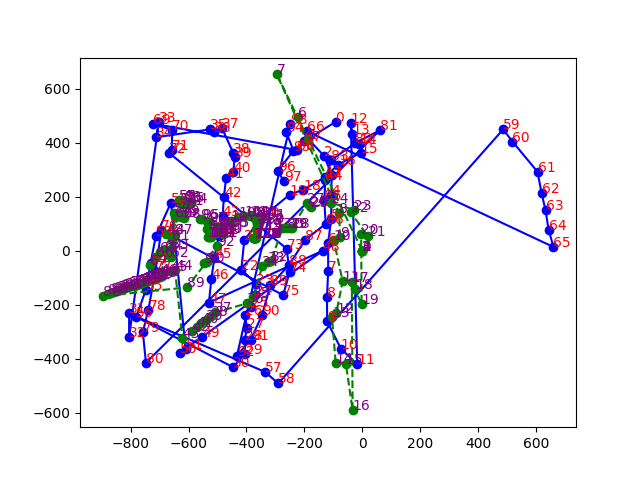

In [23]:
plt.figure()
plt.plot(box_traj[:, 0], box_traj[:, 1], 'bo-')
plt.plot(kmf_traj[:, 0], kmf_traj[:, 1], 'go--')
for i, pt in enumerate(box_traj):
    plt.text(pt[0],pt[1], i, color='red')
for i, pt in enumerate(kmf_traj):
    plt.text(pt[0],pt[1], i, color='purple')


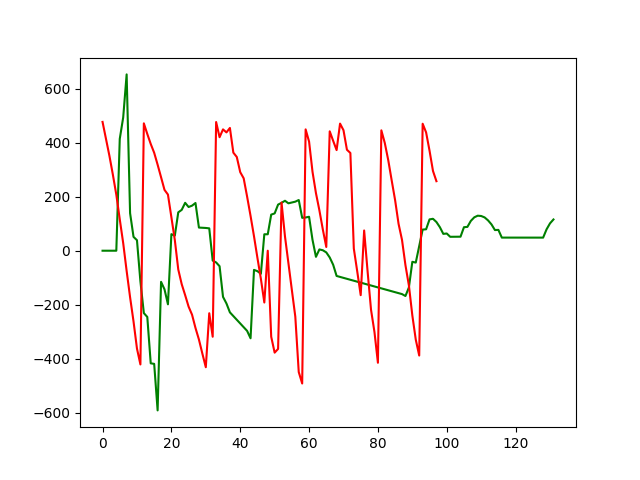

In [29]:
plt.figure()
plt.plot(kmf_traj[:, 1], 'g')
plt.plot(box_traj[:, 1], 'r')

# ORB matching and highlighting plant

In [4]:
cv2.namedWindow("test", cv2.WINDOW_NORMAL)
cv2.namedWindow("test_hist", cv2.WINDOW_NORMAL)
sequence = dataset.match_tags("20210806_hegnstrup_seq11")
kp_list = []
for frame in sequence:
    img = cv2.imread(frame.filepath)
    #kp_list.append(sift.detect(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))# if np.random.binomial(1,0.5,1) else None))
    start_time = time.time()
    kp = sift.detect(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    end_time = time.time()
    sift_time = end_time - start_time
    img, img_raw = draw_boxes(frame, {'ground_truth_detections_single' : (0,0,255)})
    img = cv2.drawKeypoints(img ,kp,img, color=(255,0,0))
    points = np.asarray([x.pt for x in kp])
    h,x,y, _ = plt.hist2d(points[:, 0], points[:, 1], bins=(19,12), cmap='gray')
    plt.axis('off')
    plt.savefig("test.png", bbox_inches='tight', pad_inches=0)
    hist = cv2.resize(cv2.imread("test.png"), (1920,1200))
    hist = cv2.GaussianBlur(hist, (19,11), 10.0)
    hist = np.flipud(hist)
    #img = cv2.addWeighted(img, 1.3 , hist, -0.3, 0.0)
    img_proc = cv2.addWeighted(img_raw, 1.3, hist, -0.3, 0.0)
    img = np.hstack((img, img_proc))
    img = np.vstack((img, np.hstack((img_raw, img_proc))))
    cv2.imshow("test_hist", hist)
    cv2.imshow("test", img)
    cv2.waitKey(0)
    print(sift_time)

0.4132537841796875
0.38731861114501953
0.3410935401916504
0.36730241775512695
0.3537445068359375
0.39334559440612793
0.3641088008880615
0.343853235244751
0.38269972801208496
0.36408257484436035
0.3601350784301758
0.3950338363647461
0.33310794830322266
0.35159850120544434
0.34273505210876465
0.3896515369415283
0.3770639896392822
0.5006370544433594
0.36781954765319824
0.43136048316955566
0.4503493309020996
0.45869922637939453
0.3966822624206543
0.383406400680542
0.4033050537109375
0.37523627281188965
0.34965944290161133
0.3216822147369385
0.34509849548339844


Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation
Numeric mode unsupported in the posix collation implementation


In [4]:
cv2.destroyAllWindows()

In [10]:
cv2.destroyAllWindows()

In [ ]:
area_fn = lambda x: x[2]*x[3]
for key in bbox_dict:
    area = []
    box_count = []
    detections = bbox_dict[key]
    fig = plt.figure()
    ax = plt.axes()
    for detection in detections:
        if detection is not None:
            bbox_array = np.asarray(detection).reshape(-1,4)
            area.append(np.cumsum(np.apply_along_axis(area_fn, 1, bbox_array)[-1]))
            box_count.append(bbox_array.shape[0])
    ax.plot(area)
    ax.twinx().plot(box_count, color='yellow')
        

# IMU, GPS and Odometry data
This section analyzes the relationships between the data and how to make use of these to make a reliable weed detection framework 